---
# Advanced Lane Finding

Udacity - Self-Driving Car NanoDegree

In this project, an advanced lane detection algorithm was impelemented. Below an overview of the pipeline and relevant results are presented. The ipython file with the corresponding code is the calibrate.py

## Pipeline

1. Camera calibration and distortion matrix calculation
2. For a given image do
3. Unistort image
4. Transform image street perpective
5. Apply sobel, color and s-channel filtering
6. Slice the image and create histograms of lane points per slice
7. Smooth the histograms and extract local maximum points
8. If two maximum's are found, one on the left and one on the right, fit a polygonal on each side
9. Calculate curvature per polynomial
10. Filter polynomials if curvatures do not match
11. Invert project lanes to original image space


### Basic imports

In [1]:
import imageio
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import glob
from scipy import signal
from scipy.signal import find_peaks_cwt
from scipy.signal import argrelextrema
from moviepy.editor import VideoFileClip
import scipy.misc
import matplotlib.gridspec as gridspec
from scipy.spatial import distance



## 1. Apply distortion-correction to raw image.

### Load calibration images

I load all calibration images to the array: image_list

In [2]:


%matplotlib inline

nx = 9
ny = 6

image_list = []
for filename in glob.glob('camera_cal/*.jpg'):
    image_list.append(cv2.imread(filename))
    
print('Done!')


Done!


### Calibrate to generate coefficients

First I convert the images to grayscale and then apply the findChessboardCorners to get all corners. The calibrateCamera method of opencv eventually generates the camera matrix and coefficients.

In [3]:

objpoints = []
imgpoints = []
    
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
for image in image_list:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera( objpoints, 
                                                        imgpoints, 
                                                        gray.shape[::-1], 
                                                        None, 
                                                        None)

print('Done!')


Done!


### The undistort method

The cv2.undistort method can undistort an image given the camera matrix and coefficients

In [4]:
def undistort(img):
    img_undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, camera_matrix)
    return img_undistorted


### Load and display a test image

The undistort seems to work fine since the image on the right has been corrected to contain straight lines

Done!


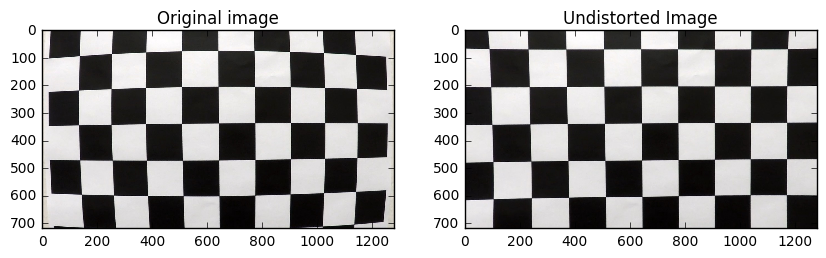

In [5]:
image = cv2.cvtColor(image_list[7], cv2.COLOR_BGR2RGB)
gs = gridspec.GridSpec(1, 2, width_ratios=[30, 30]) 

f = plt.figure(figsize=(10, 8))
f1 = plt.subplot(gs[0])
f1.imshow(image)
f1.set_title('Original image')

f2 = plt.subplot(gs[1])
f2.imshow(undistort(image))
f2.set_title('Undistorted Image')

print('Done!')

An example of undistortion on an image collected while driving

Done!


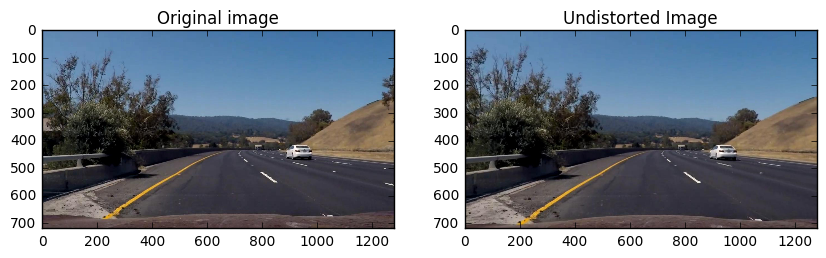

In [6]:

image = cv2.imread('./hard3/outfile617.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gs = gridspec.GridSpec(1, 2, width_ratios=[30, 30]) 

f = plt.figure(figsize=(10, 8))
f1 = plt.subplot(gs[0])
f1.imshow(image)
f1.set_title('Original image')

f2 = plt.subplot(gs[1])
f2.imshow(undistort(image))
f2.set_title('Undistorted Image')

print('Done!')

## 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

I used a combination of color, sobel x and s-channel filtering (from HLS) to generate a binary image (as shown below)

The formula used is: sobel_x AND rgb_filtering AND hls_s_channel

This indicates that a pixel is marked as possible lane if
 - the x gradient is TRUE and the s channel of HLS is inside the threshold
 
 OR
 
 - the RBG color is white or yellow 
  

### Define methods for sobel_x filtering, HLS thresholding on s-channel and RGB filtering

In [7]:

def apply_sobel_x(image, thresh_min=20, thresh_max=200):
    # Sobel x
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Apply a threshold
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary

def apply_hls_threshold(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #plt.imshow(s_channel)
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= 130) & (s_channel <= 240)) | ((l_channel >= 220) & (l_channel <= 255))] = 1
    #print(s_binary)

    return s_binary

def get_color_selection(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    lower_yellow = np.array([0, 90, 90], dtype=np.uint8)
    upper_yellow = np.array([210,250,255], dtype=np.uint8)
    
    lower_white =np.array([170,170,170], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    
    # Get the white pixels from the original image
    mask_white = cv2.inRange(image, lower_white, upper_white)

    # Get the yellow pixels from the HSV image
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # Bitwise-OR white and yellow mask
    mask = cv2.bitwise_or(mask_white, mask_yellow)
    return mask

def threshold_image(image):

    binary_sobel = apply_sobel_x(image)
    binary_hls = apply_hls_threshold(image)
    binary_rbg = get_color_selection(image)
    
    # Combine all thresholds and filters
    combined_binary = np.zeros_like(binary_sobel)
    #combined_binary[:,:,0] = binary_sobel 
    #combined_binary[:,:,1] = binary_hls 
    #combined_binary[:,:,2] = binary_rbg 
    combined_binary[((binary_sobel == 1) & (binary_hls == 1)) | (binary_rbg > 0) ] = 1
    
    return combined_binary

def merge_images(img1, img2):
    return cv2.addWeighted(img1, 0.4, img2, 0.6, 0)


The three filters and their combination:

Done!


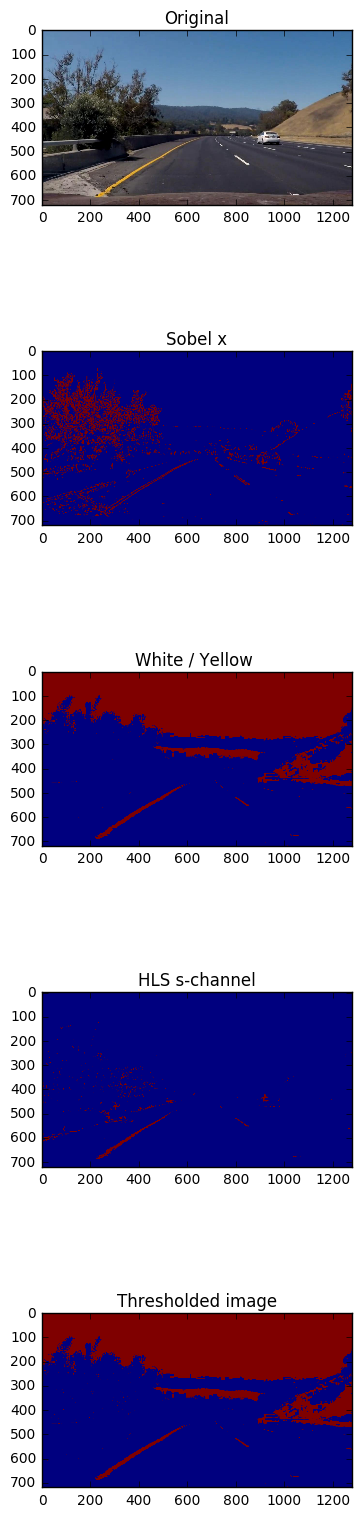

In [8]:

gs = gridspec.GridSpec(5, 1, width_ratios=[30, 30, 30, 30, 30]) 
filtered = threshold_image(image)
                           
f = plt.figure(figsize=(20, 20))
f0 = plt.subplot(gs[0])
f0.imshow(image)
f0.set_title('Original')

f1 = plt.subplot(gs[1])
f1.imshow(apply_sobel_x(image))
f1.set_title('Sobel x')

f2 = plt.subplot(gs[2])
f2.imshow(get_color_selection(image))
f2.set_title('White / Yellow ')

f3 = plt.subplot(gs[3])
f3.imshow(apply_hls_threshold(image))
f3.set_title('HLS s-channel')

f4 = plt.subplot(gs[4])
f4.imshow(filtered)
f4.set_title('Thresholded image')

print('Done!')


We can see that filtering preserves most of the lane pixels (as desired) plus additional pixels e.g. sky that will be ignored in later steps

## 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

### Define transformation points 

I use the following source and destination points found through experimentation:

| Source | 	Destination
| :- |-------------: | :-:
| 230,695 |	220, 720 
| 578,458 |	220, 0 
| 704,458 |	1060, 0 
| 1065,695 | 1060, 720 

I verify that my perspective transform is working as expected by drawing the src and dst points onto a test image

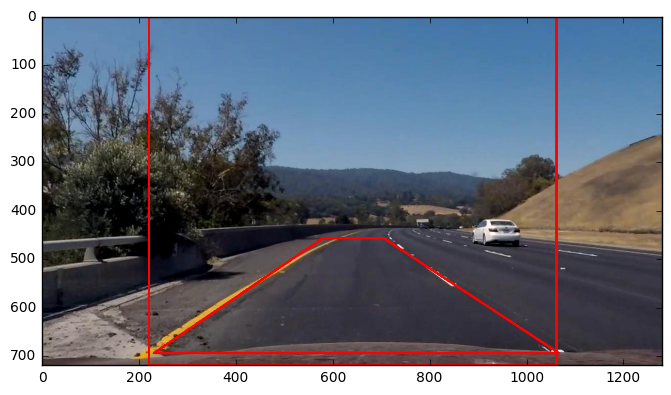

In [9]:
#find src points for projection
image = undistort(image)
h = image.shape[0]

src = np.int32([[230,695],[578,458],[704,458],[1065,695]])
dest = np.int32([[220,h],[220,0],[1060,0],[1060,h]])
#pts = pts.reshape((-1,1,2))
lanes_marked = np.copy(image)
lanes_marked = cv2.polylines(lanes_marked,[src],True,(255,0,0), thickness=3)
lanes_marked = cv2.polylines(lanes_marked,[dest],True,(255,0,0), thickness=3)

plt.figure(figsize=(8,8))
plt.imshow(lanes_marked)

### Define project and invert_project methods

To project to the street space and project back to the camera image space, I use the methods below

In [10]:
def project(image):
    
    h = image.shape[0]
    w = image.shape[1]
    src = np.float32([[230,695],[578,458],[704,458],[1065,695]])
    dst = np.float32([[220,h],[220,0],[1060,0],[1060,h]]) 

    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(image, M, (w,h))
    return warped

def invert_project(image):
    
    h = image.shape[0]
    w = image.shape[1]
    src = np.float32([[230,695],[578,458],[704,458],[1065,695]])
    dst = np.float32([[220,h],[220,0],[1060,0],[1060,h]]) 

    M = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(image, M, (w,h))
    empty = np.zeros(warped.shape, dtype=np.uint8)
    final = np.dstack((warped, empty, empty))
    return final

### Example images for perspective transformation

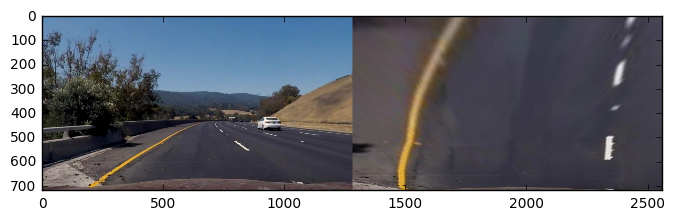

In [11]:
projected_image = project(image)
plt.figure(figsize=(8,8))
plot_image = np.concatenate((image, projected_image),axis=1) 
plt.imshow(plot_image)

## 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

Two helper methods used to measure the curvature of a lane and the distance from the car to the lane

In [12]:
ym_per_pixel = 30/720 # meters per pixel in y dimension
xm_per_pixel = 3.7/700 # meters per pixel in x dimension

def calculate_curvature(line) :
    return ((ym_per_pix**2 + xm_per_pix**2*(2*line[0]*720 + line[1])**2)**1.5)/(2*xm_per_pix*ym_per_pix*line[0])
    
def calculate_distance_to_lanes(left_lane, right_lane) :

    border_left = calculate_distance_to_lane(left_lane)
    border_right = calculate_distance_to_lane(right_lane)
    middle = (border_left + border_right) / 2.0
    diff_in_pixels = 1280/2 - middle
    diff_in_m = diff_in_pixels * xm_per_pixel
    return diff_in_m

def calculate_distance_to_lane(line) :
    y = 720
    dist = line[0]*y*y + line[1]*y + line[2]
    return dist

## 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

To identify lane pixels I am following this pipeline:

- Load a thresholded image (as described above)
- Split the image into vertical slices 
- For each vertical slice
 - Create a histogram for pixel values
 - Smooth the histogram with a generalized Gaussian shape (method: signal.general_gaussian)
 - Calculate the relative extrema of data (method: argrelextrema)
 - Split extremas to left and right lanes based on their x value
 - If only one extrema is found on each side store them for later processing
 - If two are found, check if they are close (distance < threshold)
  - If they are close store their average for later processing
 - In other cases, ignore the points for this slice
 
The method is shown below

In [13]:
def find_lane_points(image, visualize = False):
    height = image.shape[0]
    width = image.shape[1]
    window_size = 40
    left_lanes_x = []
    left_lanes_y = []
    right_lanes_x = []
    right_lanes_y = []
    
    
    gs = gridspec.GridSpec(int(height / window_size),1)
    if visualize:
        fig = plt.figure()


    for window_index in range(1,int(height / window_size)):
        window_lanes = image[window_index*window_size:(window_index+1)*window_size, :]
                           
        histogram = np.sum(window_lanes, axis=0)

        window = signal.general_gaussian(49, p=3, sig=40)
        filtered = signal.fftconvolve(window, histogram)
        filtered = (np.average(histogram) / np.average(filtered)) * filtered
        histogram = np.roll(filtered, -25)

        if visualize:
            ax = fig.add_subplot(gs[window_index])
            ax.plot(histogram)
            
        indices = argrelextrema(histogram, np.greater)

        data_y_left = []
        data_x_left = []
        data_y_right = []
        data_x_right = []
    
        for i in indices[0]:
            if histogram[i] > 8:
                if i > 600:
                    data_x_right.append(i)
                    data_y_right.append(window_size*window_index)
                else:
                    data_x_left.append(i)
                    data_y_left.append(window_size*window_index)
            
        if len(data_x_left) == 1:
            left_lanes_x.append(data_x_left[0])
            left_lanes_y.append(data_y_left[0])
        if len(data_x_left) == 2:
            if distance.euclidean((data_x_left[0], data_y_left[0]),(data_x_left[1], data_y_left[1])) < 34:
                left_lanes_x.append(int((data_x_left[0]+data_x_left[1]) / 2))
                left_lanes_y.append(int((data_y_left[0]+data_y_left[1]) / 2))

        if len(data_x_right) == 1:
            right_lanes_x.append(data_x_right[0])
            right_lanes_y.append(data_y_right[0])
        if len(data_x_right) == 2:
            if distance.euclidean((data_x_right[0], data_y_right[0]),(data_x_right[1], data_y_right[1])) < 34:
                right_lanes_x.append(int((data_x_right[0]+data_x_right[1]) / 2))
                right_lanes_y.append(int((data_y_right[0]+data_y_right[1]) / 2))

    if visualize:
        plt.show()
        
    return left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y




### Example of detected lane points

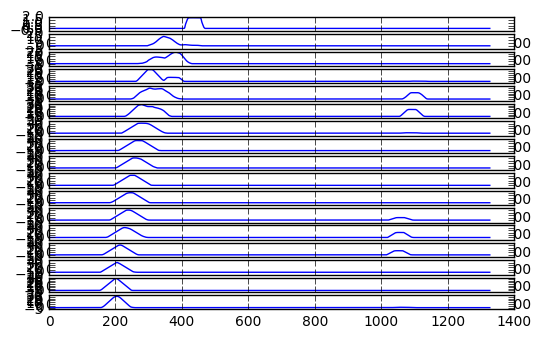

In [14]:
thresholded_image = threshold_image(projected_image)

left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y = find_lane_points(thresholded_image, True)


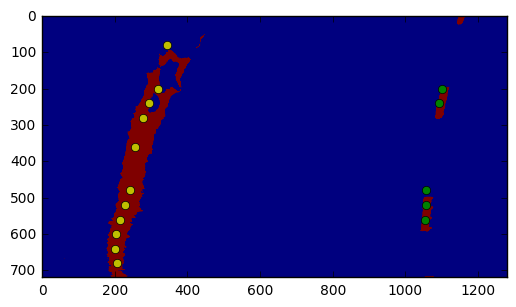

In [15]:
plt.plot(right_lanes_x, right_lanes_y, 'og')
plt.plot(left_lanes_x, left_lanes_y, 'oy')

plt.imshow(thresholded_image)

After receiving the points (yellow for left and green for right lane), I use the polyfit method for a last squares polynomial fit.

### Find lines method to fit polylines, export their detected points and return a layered image with left and right curvature

In [16]:
def find_lines(image, left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y):
    #print(left_lanes_x)
    if len(left_lanes_x) < 3:
        return False, 0, 0, 0, 0, 0
    #print(right_lanes_x)
    if len(right_lanes_x) < 3:
        return False, 0, 0, 0, 0, 0
    
    overlay_lanes = np.copy(image)

    left_line = np.polyfit(left_lanes_y, left_lanes_x, deg=2)
    x = list(range(0, image.shape[0]))
    y = list(map(int, left_line[0]*x*x + left_line[1]*x+left_line[2]))
    line1_pts = np.array([[_y,_x] for _x, _y in zip(x, y)])
    line1_pts = line1_pts.reshape((-1,1,2))
    cv2.polylines(overlay_lanes, np.int32([line1_pts]), False, color=(255,0,0), thickness=50)
    left_r = calculate_curvature(left_line)

    right_line = np.polyfit(right_lanes_y, right_lanes_x, deg=2)
    x = list(range(0, image.shape[0]))
    y = list(map(int, right_line[0]*x*x + right_line[1]*x+right_line[2]))
    line2_pts = np.array([[_y,_x] for _x, _y in zip(x, y)])
    line2_pts = line2_pts.reshape((-1,1,2))
    cv2.polylines(overlay_lanes, np.int32([line2_pts]), False, color=(255,0,0), thickness=50)
    right_r = calculate_curvature(right_line)

    top_points = [line1_pts[-1], line2_pts[-1]]
    base_points = [line1_pts[0], line2_pts[0]]
    
    # Fill in the detected lane
    cv2.fillPoly(overlay_lanes, [np.concatenate((line2_pts, line1_pts, top_points, base_points))], color=(100,200,150))
    #cv2.putText(overlay_lanes, 'Vehicle is '+position+'m left of center', (50, 100), font, 1, (255, 255, 255), 2)
#    cv2.putText(overlay_lanes, 'Radius left: '+str(left_r)+' Radius right: '+str(right_r), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 100), 2)
#    cv2.putText(final_merged, str(i), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
#    print(left_r)
    #plt.imshow(overlay_lanes)
    return True, overlay_lanes, left_r, right_r, left_line, right_line


#### Example

In [17]:
success, overlay_lanes, left_r, right_r, l1, l2 = find_lines(thresholded_image, left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y)

if success == False:
    print('success = '+str(success))
    print('Failed to extract lanes')
else:
    f, (f1, f2) = plt.subplots(1, 2)
    f1.imshow(project(image))
    f1.set_title('Projected image')
    f2.imshow(overlay_lanes)
    f2.set_title('Lane area')

TypeError: can't multiply sequence by non-int of type 'list'

## 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

In [ ]:
final = invert_project(overlay_lanes)
#print(overlay_lanes.shape)
#print(image.shape)
final_merged = merge_images(final, image)
#print(final)
plt.imshow(final_merged)

### We use a history of the last history_size frames to make more stable detections of the lanes

The approach is naive. It uses the current lane points and the previous #history_size lane points as found by the algorithm on previous frames in order to smoothen the polyline fitting approach. However, the previous lane points are not moved "backwards" due to the car motion but considered on the same frame as the current lane points. This is clearly not a good solution thus I only used a very low #history_size number

In [ ]:
history_size = 1

In [ ]:
def history(history, current):
    size = len(history)
    if size < history_size:
        return current
    if history_size == 1:
        return current
    output = current
    for i in range(1, history_size + 1):
        output = output + history[size - i]
    return output

### The main pipeline as explained above

When the two lanes have been identified, I additionally check if their curvatures match together.
The following rules are applied:
- If both curvatures are very small

OR

- If the curvatures are opposite (one negative the other positive) AND if their difference is big 


Then the current lanes are discarded as invalid and the previos lanes are used

In [ ]:
history_left_x, history_left_y, history_right_x, history_right_y = [],[],[],[]
old_distance_to_center = 0
old_lanes_image = []
i = 0
def process(image, useHistory = True):
    global old_lanes_image
    global old_distance_to_center
    
    if i >613 and i < 625:
#    if i == 563 or i == 614 or i == 610 or i == 617 or i == 1025 or i == 1032 or i == 1047:
        scipy.misc.toimage(image, cmin=0.0, cmax=255).save('hard2/outfile'+str(i)+'.jpg')
    
    undistorted = undistort(image)
    projected = project(undistorted)
    
    lanes_image = threshold_image(projected)
    
    left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y = find_lane_points(lanes_image)
    
    history_left_x.append(left_lanes_x)
    history_left_y.append(left_lanes_y)
    history_right_x.append(right_lanes_x)
    history_right_y.append(right_lanes_y)
    
    history_length = len(history_left_x)


    left_x = history(history_left_x, left_lanes_x)
    left_y = history(history_left_y, left_lanes_y)
    right_x = history(history_right_x, right_lanes_x)
    right_y = history(history_right_y, right_lanes_y)
    success, overlay_lanes, left_r, right_r, left, right = find_lines(lanes_image, left_x, left_y, right_x, right_y)

    if success == False:
        distance_to_center = old_distance_to_center
    else:
        distance_to_center = round(calculate_distance_to_lanes(left, right),2)
    
    if len(old_lanes_image) == 0:
        old_lanes_image = overlay_lanes
        
    if success == False:
        overlay_lanes = old_lanes_image
    if abs(left_r) < 280 or abs(right_r) < 280:
        overlay_lanes = old_lanes_image

    if left_r * right_r < 0:
        if abs(abs(left_r) - abs(right_r)) >2000 and (abs(left_r) < 1000 or abs(right_r) < 1000):
            overlay_lanes = old_lanes_image
        
    final = invert_project(overlay_lanes)
    final_merged = merge_images(final, image)
    
    old_lanes_image = overlay_lanes
    
    global i
    if distance_to_center > 0: 
        distance_to_center_desc = "right"
    else :
        distance_to_center_desc = "left"
    cv2.putText(final_merged, 'Frame: '+str(i), (50,80), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 100), 2)
    cv2.putText(final_merged, 'Left curvature: '+str(round(abs(left_r),2))+' Right curvature: '+str(round(abs(right_r),2)), (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 100), 2)
    cv2.putText(final_merged, 'Car position: '+str(abs(distance_to_center))+' meters on the '+distance_to_center_desc+' from the center of the lane', (50, 160), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 100), 2)
    

    i = i + 1
    return final_merged
print('Done!')

## Pipeline (video)
### Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Below you can find the code to generate the labeled video 

In [ ]:

white_output = './project_video_labeled.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

## Discussion

1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

Currently, the lanes are detected almost perfectly on the first video. We can easily observe that the bottom right and left corners of the lane area are moving (but are still acceptable) a lot between subsequent frames. 
On the challenge video the results were worse but not too bad. 

I believe that the current pipeline can be improved in the following two ways (at least): 
1. The current estimate should consider also the previous lane estimates. If done correctly, it could lead to much more stable results.
2. The process of finding lane pixels can be also improved in order to detect lanes that are very light colored or under different lightning conditions


### Further results on some difficult cases

In [ ]:
global i
i = 0
for filename in sorted(glob.glob('hard3/*.jpg')):
    plt.figure(figsize=(6,6))
    #print(filename)
    out = cv2.cvtColor(process(cv2.imread(filename), True), cv2.COLOR_BGR2RGB)
    plt.imshow(out)
    i = i + 1
print('Done!')
